<a href="https://colab.research.google.com/github/jjovalle99/real_estate_offers_ml/blob/main/Real_Estate_Analysis_Bogota.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 12 16:46:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Table of Content
---
* [Libraries](#0)
* [1. Initial Data Exploration](#1)
* [2. Real Estate Offers per UPL](#2)
* [3. Spatial Autocorrelation](#3)
* [4. Real Estate Price Prediciton](#4)
  

## **Libraries**<a class="anchor" id="0"></a>


---


In [ ]:
# !pip install geopandas
# !pip install pysal
# !pip install contextily
# !pip install category_encoders
# !pip install cudf-cu11 cuml-cu11 --extra-index-url=https://pypi.nvidia.com

In [3]:
import requests
import io
import zipfile
import json

import pandas as pd
import geopandas as gpd
import numpy as np

import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

from pysal.lib import weights
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot

from shapely.geometry import Polygon, Point

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import cudf
import cuml

plt.style.use("ggplot")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option('display.float_format', '{:.2f}'.format)

/usr/local/lib/python3.10/dist-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/usr/local/lib/python3.10/dist-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/usr/local/lib/python3.10/dist-packages/libpysal/cg/alpha_shapes.py:199: NumbaDepre

## **1. Initial Data Exploration**<a class="anchor" id="1"></a>

---



#### 1.1 Data Loading

In [4]:
# The urls are defined as variables.
url_1 = "https://datosabiertos.bogota.gov.co/dataset/808582fc-ffc8-4649-8428-7e1fd8d3820c/resource/a5c8c591-0708-420f-8eb7-9f3147e21c40/download/unidadplaneamientolocal.json"
url_2 = "https://storage.googleapis.com/pruebas-data-analitica/inmuebles_full.csv.gz"

In [5]:
# Load the UPLs table.
with requests.get(url_1) as url:
    data = json.loads(url.content)
upls_df = pd.json_normalize(data["features"])

# Load the real estate table.
inmuebles_df = pd.read_csv(url_2, compression='gzip')

#### 1.2 UPLs

In [6]:
# Inspect the entire json file
data.keys()

dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features'])

In [7]:
# Inspect loaded pandas dataframe
print(f"Rows: {upls_df.shape[0]}, Cols: {upls_df.shape[1]}")
upls_df.head()

Rows: 33, Cols: 18


,attributes.OBJECTID,attributes.CODIGO_UPL,attributes.NOMBRE,attributes.ACTO_ADMINISTRATIVO,attributes.NUMERO_ACTO_ADMINISTRATIVO,attributes.FECHA_ACTO_ADMINISTRATIVO,attributes.NORMATIVA,attributes.VOCACION,attributes.OBSERVACION,attributes.AREA_HA,attributes.SECTOR,attributes.ESCALA_CAPTURA,attributes.FECHA_CAPTURA,attributes.RESPONSABLE,attributes.RULEID,attributes.SHAPE_Length,attributes.SHAPE_Area,geometry.rings
0,1,UPL13,Tintal,DEC,555,1640736000000,En el marco del Decreto 555 del 29 de diciembr...,Urbano-Rural,Que mediante Resolución 2050 del 23 de noviemb...,1284.99,Sector Sur Occidente,,1669161600000,553,1,0.15,0.00,"[[[-74.16956596732314, 4.656317873712112], [-7..."
1,2,UPL30,Salitre,DEC,555,1640736000000,En el marco del Decreto 555 del 29 de diciembr...,Urbano,Que mediante Resolución 2050 del 23 de noviemb...,1578.49,Sector Occidente,,1669161600000,553,1,0.14,0.00,"[[[-74.09470711860138, 4.664781414700315], [-7..."
2,3,UPL22,Restrepo,DEC,555,1640736000000,En el marco del Decreto 555 del 29 de diciembr...,Urbano,Que mediante Resolución 2050 del 23 de noviemb...,1075.50,Sector Centro Ampliado,,1669161600000,553,1,0.14,0.00,"[[[-74.10458595480793, 4.564668384705101], [-7..."
3,4,UPL31,Puente Aranda,DEC,555,1640736000000,En el marco del Decreto 555 del 29 de diciembr...,Urbano,Que mediante Resolución 2050 del 23 de noviemb...,1731.11,Sector Centro Ampliado,,1669161600000,553,1,0.16,0.00,"[[[-74.0831989468602, 4.624698289489913], [-74..."
4,5,UPL32,Teusaquillo,DEC,555,1640736000000,En el marco del Decreto 555 del 29 de diciembr...,Urbano,Que mediante Resolución 2050 del 23 de noviemb...,1419.32,Sector Centro Ampliado,,1669161600000,553,1,0.15,0.00,"[[[-74.07160498355148, 4.617747838630066], [-7..."


There are 33 rows, which coincides with the 33 Local Planning Units (UPLs) in Bogota (https://www.sdp.gov.co/micrositios/pot/upl).

In [8]:
# Verify that the OBJECTID is unique
upls_df["attributes.OBJECTID"].nunique()

33

In [9]:
# The UPL codes, names and respective variables are inspected.
upls_df[["attributes.CODIGO_UPL", "attributes.NOMBRE", "attributes.VOCACION", "attributes.SECTOR"]] \
.sort_values("attributes.CODIGO_UPL")

,attributes.CODIGO_UPL,attributes.NOMBRE,attributes.VOCACION,attributes.SECTOR
23,UPL01,Sumapáz,Rural,Sector Rural
21,UPL02,Cuenca del Tunjuelo,Rural,Sector Rural
14,UPL03,Arborizadora,Urbano-Rural,Sector Sur Oriente
27,UPL04,Lucero,Urbano-Rural,Sector Sur Oriente
25,UPL05,Usme - Entrenubes,Urbano-Rural,Sector Sur Oriente
31,UPL06,Cerros Orientales,Rural,Sector Rural
22,UPL07,Torca,Urbano-Rural,Sector Norte
24,UPL08,Britalia,Urbano-Rural,Sector Norte
32,UPL09,Suba,Urbano,Sector Noroccidente
19,UPL10,Tibabuyes,Urbano-Rural,Sector Noroccidente


Text(0, 0.5, 'UPL')

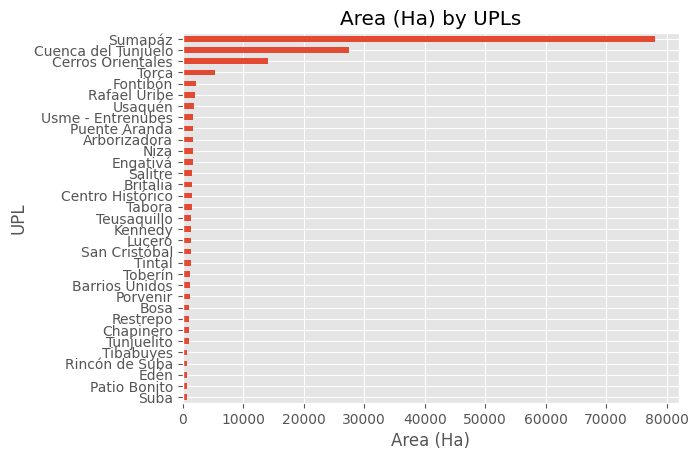

In [10]:
upls_df[["attributes.NOMBRE", "attributes.AREA_HA"]] \
.sort_values("attributes.AREA_HA") \
.plot(kind="barh", x="attributes.NOMBRE", legend=None)

plt.title("Area (Ha) by UPLs")
plt.xlabel("Area (Ha)")
plt.ylabel("UPL")

Text(0, 0.5, 'UPL')

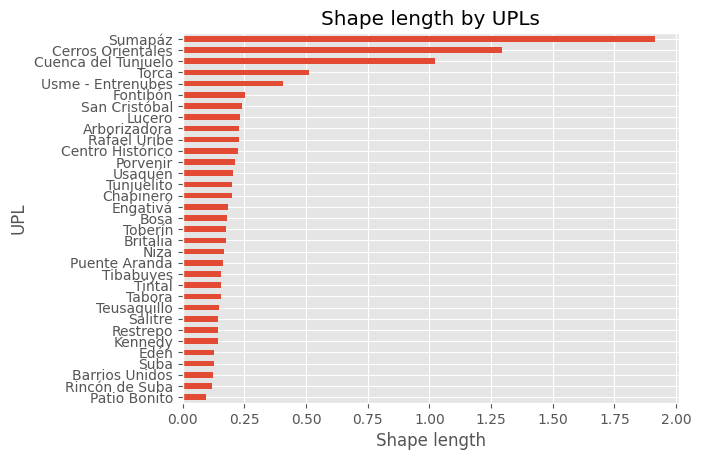

In [11]:
upls_df[["attributes.NOMBRE", "attributes.SHAPE_Length"]] \
.sort_values("attributes.SHAPE_Length") \
.plot(kind="barh", x="attributes.NOMBRE", legend=None)

plt.title("Shape length by UPLs")
plt.xlabel("Shape length")
plt.ylabel("UPL")

Text(0, 0.5, 'UPL')

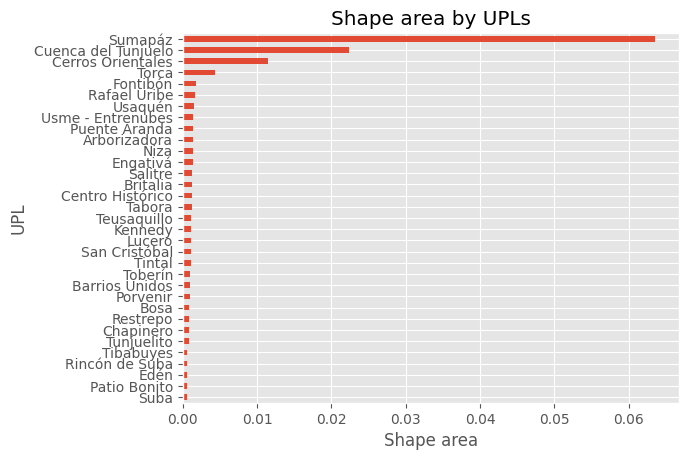

In [12]:
upls_df[["attributes.NOMBRE", "attributes.SHAPE_Area"]] \
.sort_values("attributes.SHAPE_Area") \
.plot(kind="barh", x="attributes.NOMBRE", legend=None)

plt.title("Shape area by UPLs")
plt.xlabel("Shape area")
plt.ylabel("UPL")

In [13]:
# The structure of the rings that make up the UPL polygons are inspected
upls_df["geometry.rings"][0][0]

[[-74.16956596732314, 4.656317873712112],
 [-74.1695479506406, 4.656308973122691],
 [-74.1694867040137, 4.656278717262126],
 [-74.16943626651323, 4.656276593719724],
 [-74.16938501098593, 4.656274434946454],
 [-74.16901255548419, 4.656258750760628],
 [-74.16795029641895, 4.6562881512844],
 [-74.16765389988905, 4.656381716145347],
 [-74.16721588322469, 4.656670988018277],
 [-74.16699751752685, 4.6573772454654545],
 [-74.16681193984385, 4.657854080758511],
 [-74.16670113990324, 4.658410626719785],
 [-74.16670113720085, 4.658410642087063],
 [-74.16672613072012, 4.658646600757095],
 [-74.16673753934128, 4.658754305848163],
 [-74.16673754114356, 4.65875432121527],
 [-74.16666043256936, 4.659218950939817],
 [-74.16652575265886, 4.659615243809412],
 [-74.16637251153753, 4.6597709052878145],
 [-74.16620746604093, 4.659875044732814],
 [-74.16593890379664, 4.6598538057805285],
 [-74.16564105967166, 4.659718038200197],
 [-74.16564061099143, 4.659717111665657],
 [-74.16551384627138, 4.659455263924

In [14]:
# Variables with a single value are inspected.
print(f"ACTO_ADMINISTRATIVO: {upls_df['attributes.ACTO_ADMINISTRATIVO'].unique()}")
print(f"NUMERO_ACTO_ADMINISTRATIVO: {upls_df['attributes.NUMERO_ACTO_ADMINISTRATIVO'].unique()}")
print(f"FECHA_ACTO_ADMINISTRATIVO: {upls_df['attributes.FECHA_ACTO_ADMINISTRATIVO'].unique()}")
print(f"NORMATIVA: {upls_df['attributes.NORMATIVA'].unique()}")
print(f"OBSERVACION: {upls_df['attributes.OBSERVACION'].unique()}")
print(f"ESCALA_CAPTURA: {upls_df['attributes.ESCALA_CAPTURA'].unique()}")
print(f"RESPONSABLE: {upls_df['attributes.RESPONSABLE'].unique()}")
print(f"RULEID: {upls_df['attributes.RULEID'].unique()}")

ACTO_ADMINISTRATIVO: ['DEC']
NUMERO_ACTO_ADMINISTRATIVO: ['555']
FECHA_ACTO_ADMINISTRATIVO: [1640736000000]
NORMATIVA: ['En el marco del Decreto 555 del 29 de diciembre de 2021 - Por el cual se adopta la revisión general del Plan de Ordenamiento Territorial de Bogotá']
OBSERVACION: ['Que mediante Resolución 2050 del 23 de noviembre de 2022 Por la cual se realiza la distribución de las localidades y territorios a cargo de las Subdirecciones de Planeamiento Local']
ESCALA_CAPTURA: [' ']
RESPONSABLE: ['553']
RULEID: [1]


#### 1.3 Real Estate

In [15]:
print(f"Rows: {inmuebles_df.shape[0]}, Cols: {inmuebles_df.shape[1]}")
inmuebles_df.head()

Rows: 882888, Cols: 16


,id,fecha_creacion,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,direccion,anos_antiguedad,tipo_inmueble,tiponegocio
0,3669162,2022-03-02,3.36,-76.50,VALLE DEL CAUCA,CALI,3.00,2,81.00,264000000.00,0,1,Carrera 99A # 45 - 200 Apto 706 Torre 3 Lili d...,12,apartamento,venta
1,3067524,2021-12-12,6.14,-75.60,ANTIOQUIA,SABANETA,2.00,3,90.00,460000000.00,1,2,Calle 70A SUR # 35 - 340 Apto 3402 Urbanizacio...,4,apartamento,venta
2,3944108,2022-03-18,4.90,-74.04,CUNDINAMARCA,CAJICÁ,3.00,4,140.00,1000000000.00,0,4,abaco,4,casa,venta
3,500215,2020-07-23,6.12,-75.43,ANTIOQUIA,RIONEGRO,3.00,2,75.00,1600000.00,0,1,CALLE 32 52B- 150,1,apartamento,arriendo
4,741346,2020-09-15,4.94,-73.98,CUNDINAMARCA,SOPÓ,4.00,5,750.00,3300000000.00,0,6,AUTOPISTA NORTE KM 33,12,casa,venta


In [16]:
# Check that the distinct number of ids in the table is equal to the number of rows
inmuebles_df.id.nunique()

882888

In [17]:
# The date range of the properties is inspected
print(f"Real estate posted between {pd.to_datetime(inmuebles_df.fecha_creacion).min()} \
y {pd.to_datetime(inmuebles_df.fecha_creacion).max()}")

Real estate posted between 2020-04-14 00:00:00 y 2022-07-16 00:00:00


Text(0.5, 0, '%')

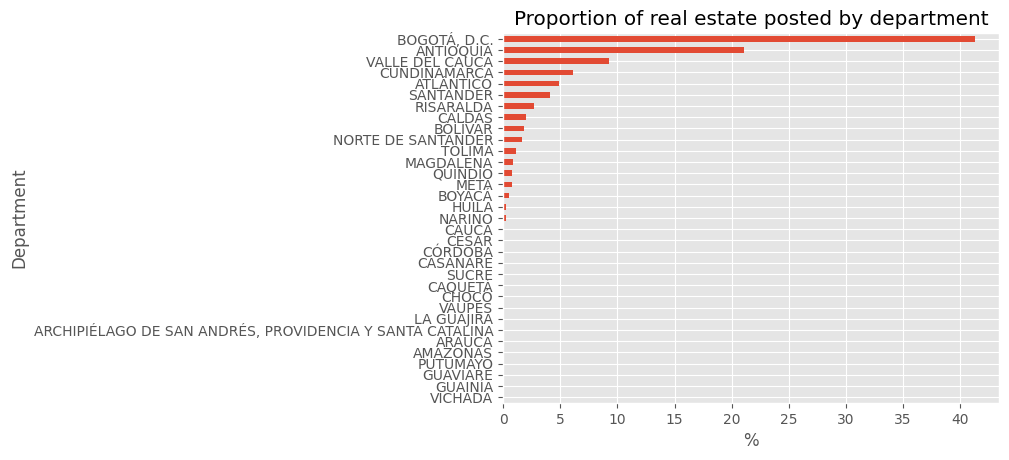

In [18]:
# The number of properties by department is inspected
(inmuebles_df.departamento.value_counts(True).sort_values() * 100).plot(kind="barh")
plt.title("Proportion of real estate posted by department")
plt.ylabel("Department")
plt.xlabel("%")

Text(0.5, 0, '%')

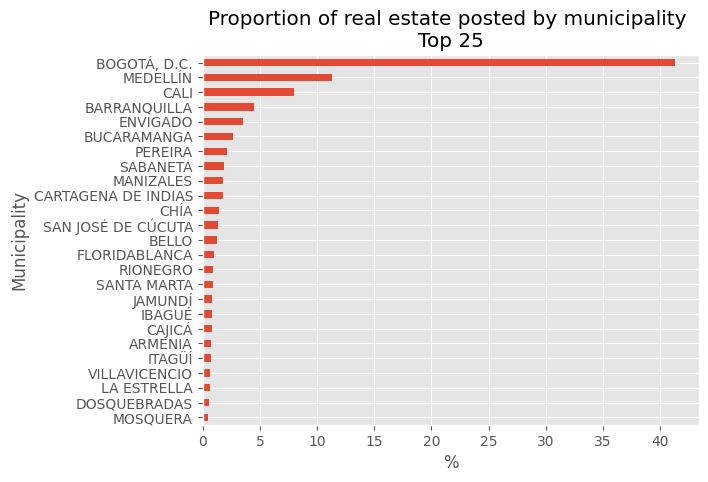

In [19]:
# The number of properties by municipality is inspected
(inmuebles_df.municipio.value_counts(True).sort_values() * 100).tail(25).plot(kind="barh")
plt.title("Proportion of real estate posted by municipality \
\nTop 25")
plt.ylabel("Municipality")
plt.xlabel("%")

Text(0.5, 0, '')

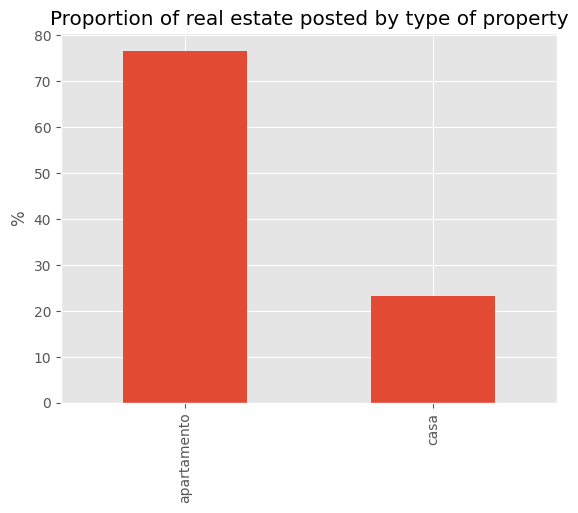

In [20]:
# The number of properties by type of property is inspected
(inmuebles_df.tipo_inmueble.value_counts(True) * 100).plot(kind="bar")
plt.title("Proportion of real estate posted by type of property")
plt.ylabel("%")
plt.xlabel("")

Text(0.5, 0, '')

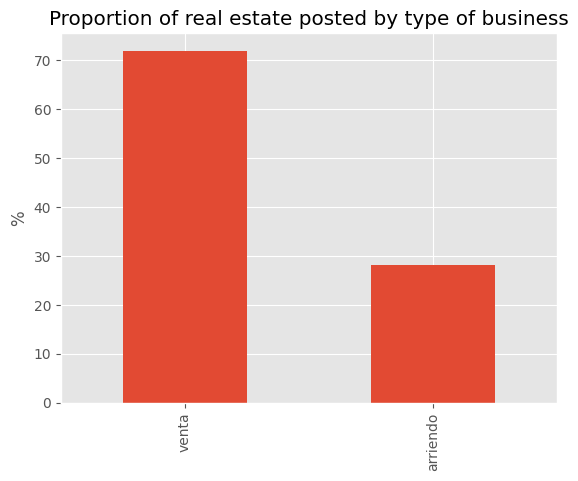

In [21]:
# The number of properties by type of business is inspected
(inmuebles_df.tiponegocio.value_counts(True) * 100).plot(kind="bar")
plt.title("Proportion of real estate posted by type of business")
plt.ylabel("%")
plt.xlabel("")

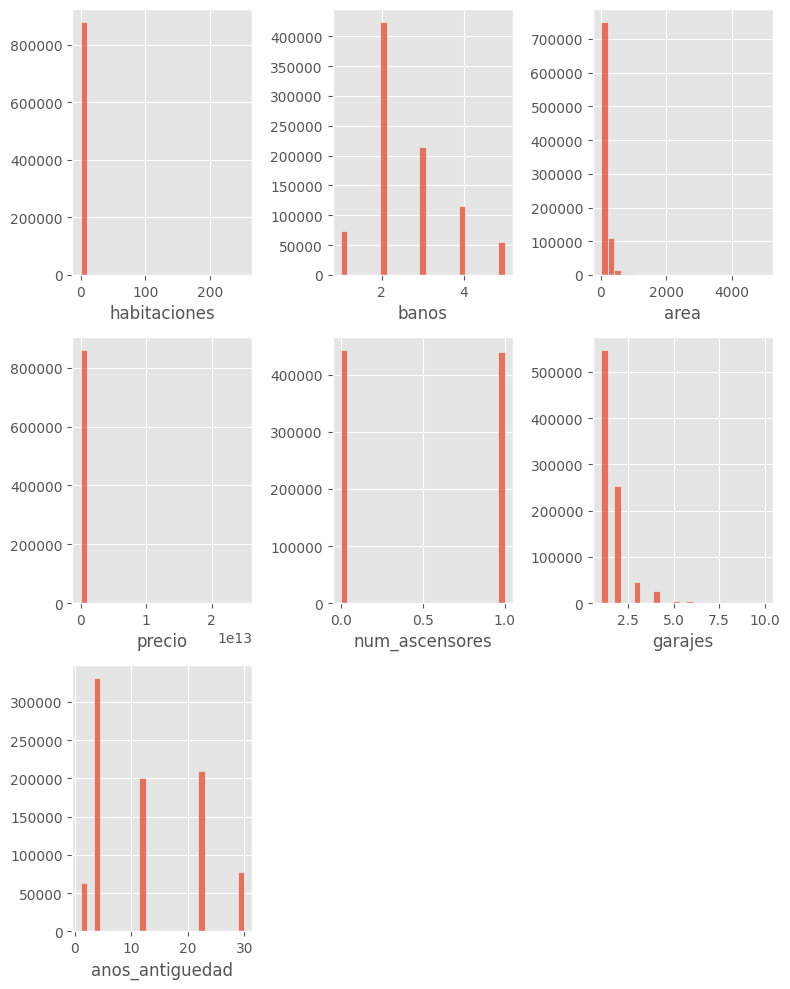

In [22]:
# Inspect the numeric variables
num_vars = ["habitaciones", "banos", "area", "precio", "num_ascensores", "garajes", "anos_antiguedad"]
fig, ax = plt.subplots(3, 3, figsize=(8, 10))

ax_flat = ax.flatten()

for idx, ax_i in enumerate(ax_flat[:len(num_vars)]):
    var = num_vars[idx]
    sns.histplot(inmuebles_df[var], ax=ax_i, bins=25)
    ax_i.set_ylabel("")

for ax_i in ax_flat[len(num_vars):]:
    fig.delaxes(ax_i)

fig.tight_layout()

## **2. Real Estate Offers per UPL**<a class="anchor" id="2"></a>

---



According to the GeoPandas documentation, to create a GeoDataFrame you need a shapely object. With this in mind, in the case of the UPLs data frame a Polygon will be used and for the real estate data frame a Point will be used.

In [23]:
# Convert upls to GeoDataFrame
upls_gdf = gpd.GeoDataFrame(
    upls_df, geometry=upls_df["geometry.rings"].apply(lambda x: Polygon(x[0])), crs="EPSG:4686"
)

Text(0.5, 1.0, 'UPLs Bogota')

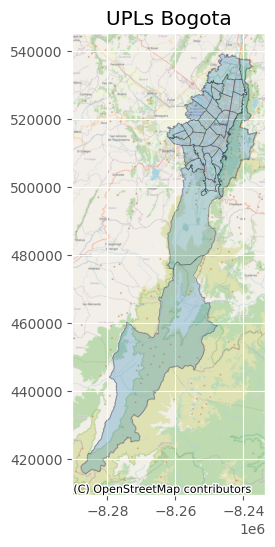

In [24]:
# The polygon is displayed
# To get correct displays, change the crs to match the basemap.
# However, for calculations and other operations the crs will still be EPSG:4686.
ax = upls_gdf.to_crs(epsg=3857).plot(figsize=(8, 6), alpha=0.3, edgecolor="k")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("UPLs Bogota")

In [25]:
# Convert real estate to GeoDataFrame
inmuebles_gdf = gpd.GeoDataFrame(
    inmuebles_df, geometry=gpd.points_from_xy(x=inmuebles_df.longitud, y=inmuebles_df.latitud), crs="EPSG:4686"
)

Text(0.5, 1.0, 'Real estate offers (Colombia)')

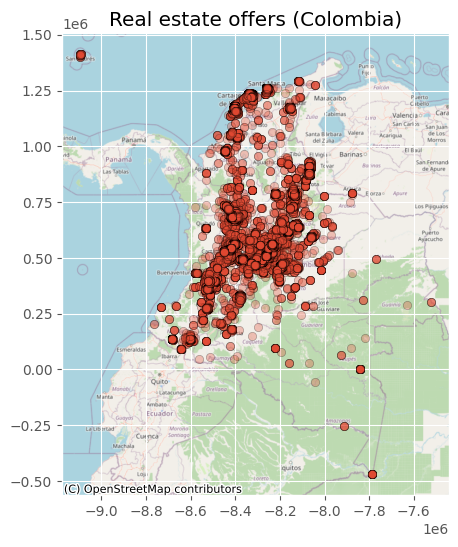

In [26]:
# Visualize real estate offers
ax = inmuebles_gdf.to_crs(epsg=3857).plot(figsize=(8, 6), alpha=0.3, edgecolor="k")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Real estate offers (Colombia)")

The spatial join is now used to obtain the property count by UPL. We use within since we want the match to be made when the geometry of A (left table) is completely in geometry B (right table). We also leave the default how parameter (inner) to have the properties that are within the UPL.

In [27]:
# Perform the spatial join
joined_gdf = gpd.sjoin(inmuebles_gdf, upls_gdf, predicate="within")

Text(0.5, 1.0, 'Real estate offers (UPLs Bogota)')

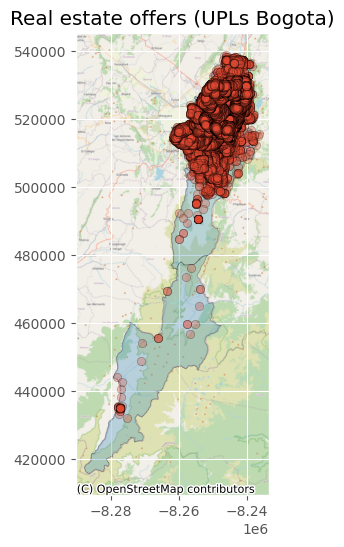

In [28]:
# The properties within the polygon are displayed
fig, ax = plt.subplots(figsize=(8, 6))
upls_gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.3, edgecolor="k")
joined_gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.3, edgecolor="k")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Real estate offers (UPLs Bogota)")

In [29]:
# Show how many real estate offers exist by UPL
result_df = joined_gdf.groupby("attributes.NOMBRE").size() \
.sort_values(ascending=False).to_frame("Conteo")
result_df

,Conteo
attributes.NOMBRE,
Usaquén,104775
Chapinero,61630
Niza,34948
Britalia,27014
Teusaquillo,17935
Salitre,15419
Toberín,14609
Barrios Unidos,11034
Centro Histórico,10543


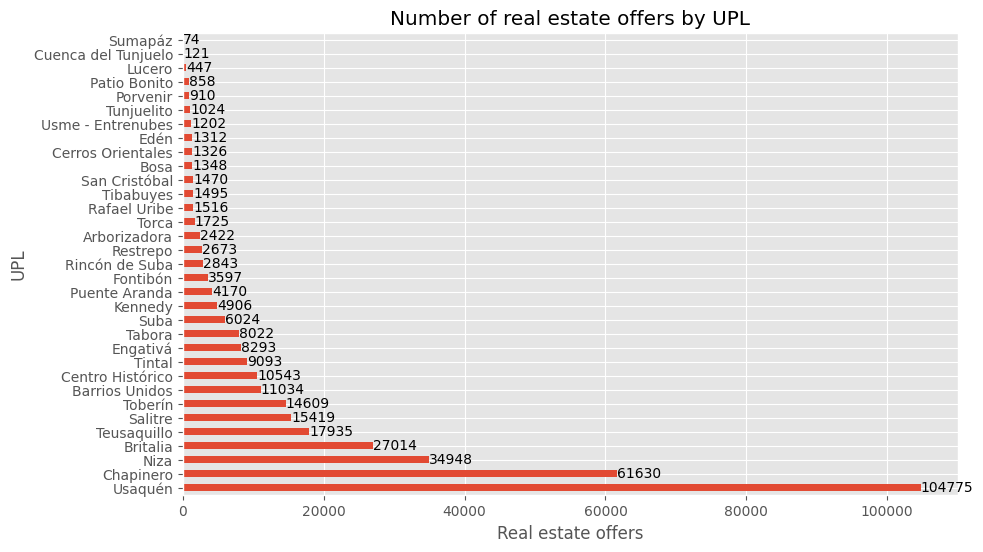

In [30]:
ax = result_df.plot(kind="barh", figsize=(10, 6), legend=None)

for i in ax.patches:
    ax.text(i.get_width(), i.get_y(), str(i.get_width()), fontsize=10)

plt.title("Number of real estate offers by UPL")
plt.ylabel("UPL")
plt.xlabel("Real estate offers")
plt.show()

## **3. Spatial Autocorrelation**<a class="anchor" id="3"></a>

A Moran's i will be carried out to find out the UPLs HH, HL, LH and LL according to the model for the value per m2 of the properties by UPL.

In [31]:
# The price per square meter is calculated
joined_gdf["valor_m2"] = joined_gdf["precio"] / joined_gdf["area"]

Text(0, 0.5, 'UPL')

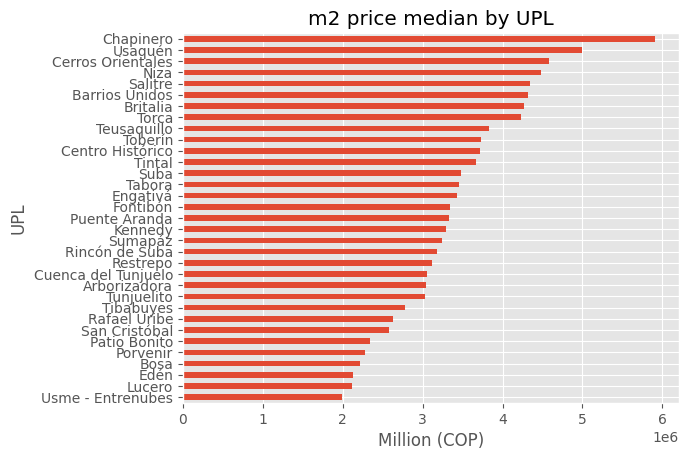

In [32]:
# The median price per m2 per UPL is displayed
m2_per_upl = joined_gdf.groupby("attributes.NOMBRE")["valor_m2"].median().to_frame()
m2_per_upl.sort_values("valor_m2").plot(kind="barh", legend=None)
plt.title("m2 price median by UPL")
plt.xlabel("Million (COP)")
plt.ylabel("UPL")

In [33]:
# The geometry of the original UPL GeoDataFrame is retrieved
m2_per_upl_gdf = upls_gdf[["attributes.NOMBRE", "geometry"]].merge(m2_per_upl, left_on="attributes.NOMBRE", right_index=True)

Text(0.5, 1.0, 'm2 Value\nUPL Bogota')

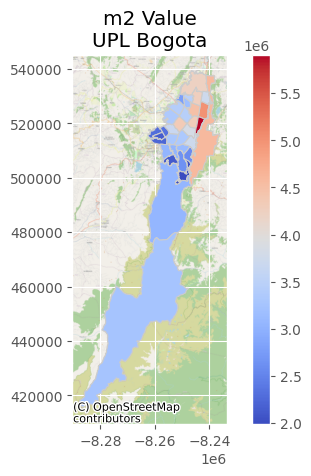

In [34]:
# The value per m2 is displayed by UPLs
ax = m2_per_upl_gdf.to_crs(epsg=3857).plot(column="valor_m2", cmap='coolwarm', linewidth=0.8, edgecolor='0.8', legend=True)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("m2 Value\nUPL Bogota")

To calculate Moran's i we first need to calculate the matrix of spatial weights of the UPLs. In this case, the `Queen` method will be used, which defines neighbors as those areas that share at least one point in common with another area (that is, contiguous areas). Then, we normalize the weight matrix so that the sum of the weights of each location is 1, thus ensuring that all locations have the same impact on the spatial autocorrelation calculation.

In [35]:
# Calculate the matrix of spatial weights
w = weights.Queen.from_dataframe(m2_per_upl_gdf)
w.transform = 'r'

We calculate the Moran I Global index using the
column `value_m2` and our matrix of spatial weights `w`.

In [36]:
# Calculate the Moran's index
moran = Moran(m2_per_upl_gdf["valor_m2"], w)
print(f"Moran I: {moran.I}")
print(f"P-value: {moran.p_sim}")

Moran I: 0.5590249488846525
P-value: 0.001


A global Moran index of 0.56 indicates a moderate positive spatial autocorrelation. This implies that there is a moderate tendency for UPLs with high m2 value to be surrounded by other UPLs with high m2 value, and for UPLs with low m2 value to be surrounded by other UPLs with low m2 value.

With a significance level of 5% (95% confidence), by rejecting the null hypothesis, it can be concluded that there is statistical evidence to support the presence of spatial autocorrelation in the data, indicating that the observed clustering or dispersion is not result of chance.

Text(2, -1, 'HL')

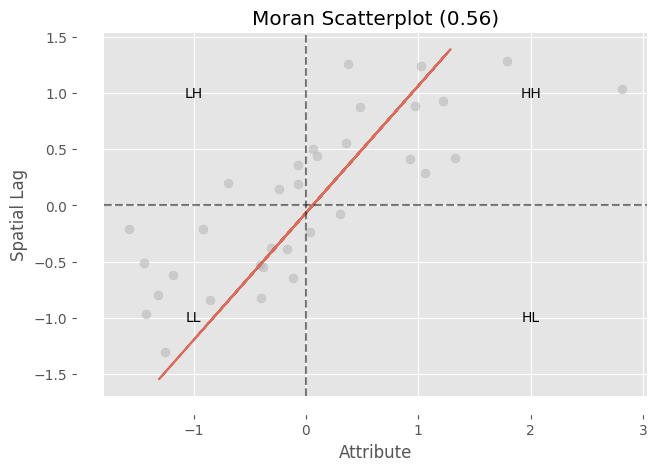

In [37]:
# Plot the Moran's index
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.text(2, 1, "HH", ha="center", va="center")
plt.text(-1, -1, "LL", ha="center", va="center")
plt.text(-1, 1, "LH", ha="center", va="center")
plt.text(2, -1, "HL", ha="center", va="center")

As can be seen in the graph, the quadrants with the highest number of observations are High-High and Low-Low, which supports the findings found previously.

We now turn to the calculation of the Local Moran Index, which allows us to identify which particular regions are contributing to the spatial autocorrelation that we observe.

In [38]:
# Calculate local Moran
moran_local = Moran_Local(m2_per_upl_gdf["valor_m2"], w)

In [39]:
# Add the results to the GeoDataFrame
m2_per_upl_gdf["moran_loc"] = moran_local.Is # 'moran_loc' will be the Local Moran Index for each UPL
m2_per_upl_gdf["quadrant"] = moran_local.q # 'quadrant' will be the quadrant to which each UPL belongs in the Moran scatterplot (HH, LH, LL, HL)
m2_per_upl_gdf["quadrant"] = m2_per_upl_gdf["quadrant"].map({1:"HH", 2: "LH", 3: "LL", 4: "HL"})

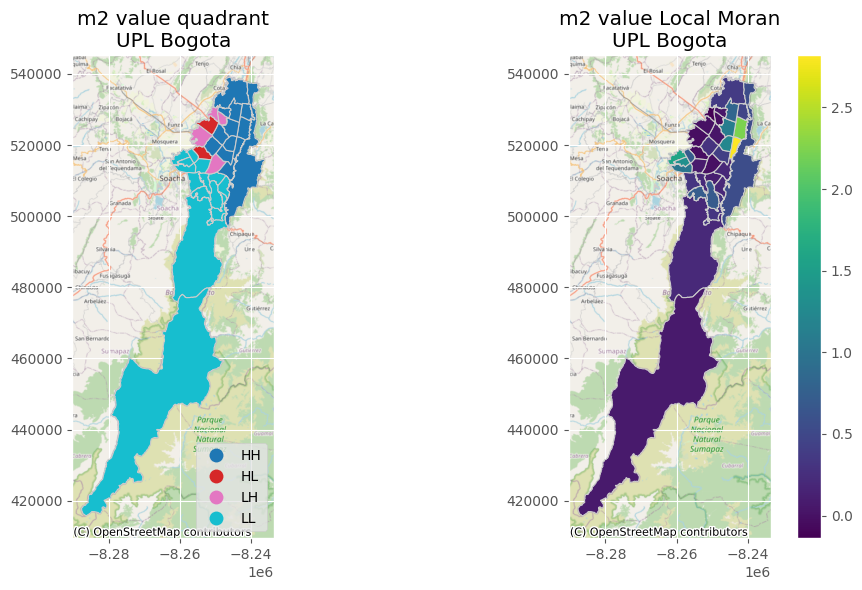

In [40]:
# The UPLs Bogota quadrant is displayed
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
m2_per_upl_gdf.to_crs(epsg=3857).plot(ax=ax[0], column="quadrant", linewidth=0.8, edgecolor='0.8', legend=True, legend_kwds={"loc": 4})
ctx.add_basemap(ax=ax[0], zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)
ax[0].set_title("m2 value quadrant\nUPL Bogota")

m2_per_upl_gdf.to_crs(epsg=3857).plot(ax=ax[1], column="moran_loc", linewidth=0.8, edgecolor='0.8', legend=True)
ctx.add_basemap(ax=ax[1], zoom=10, source=ctx.providers.OpenStreetMap.Mapnik)
ax[1].set_title("m2 value Local Moran\nUPL Bogota")

fig.tight_layout()

These maps show us in which parts of Bogotá the high values of m2 are surrounded by other high values (HH), in which parts the low values are surrounded by other low values (LL), and where the mixed ones (HL and LH) occur.

## **4. Real Estate Price Prediction**<a class="anchor" id="4"></a>

In [41]:
# A copy of the data is created to start modeling.
model_df = inmuebles_gdf.copy()
# Discard variables that are not useful for our task
model_df = model_df.drop(["id", "fecha_creacion", "direccion"], axis=1)

### 4.1 Missing Values


In [42]:
# Check for missing values
model_df.isna().sum().to_frame("# NAs").merge(
    round((model_df.isna().sum() * 100 / model_df.shape[0] ), 3).to_frame("% NAs"), right_index=True, left_index=True
)

,# NAs,% NAs
latitud,0,0.00
longitud,0,0.00
departamento,0,0.00
municipio,0,0.00
habitaciones,741,0.08
banos,0,0.00
area,0,0.00
precio,22205,2.52
num_ascensores,0,0.00
garajes,0,0.00


- There are 741 (0.084%) properties that do not have information regarding the number of rooms.
- There are 22205 (2.515%) observations that do not present the price of the property.

#### 5.1.1 Rooms

Text(0.5, 1.0, 'Real estate without # rooms informations')

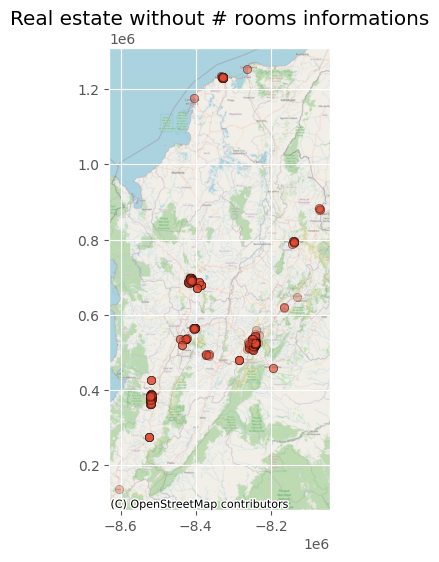

In [43]:
ax = model_df[model_df.habitaciones.isna()].to_crs(epsg=3857).plot(figsize=(6, 6), alpha=0.3, edgecolor="k")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Real estate without # rooms informations")

In [44]:
model_df[model_df.habitaciones.isna()].describe()

,latitud,longitud,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad
count,741.00,741.00,0.00,741.00,741.00,741.00,741.00,741.00,741.00
mean,5.12,-74.89,NaN,2.95,209.99,556979317.81,0.38,2.23,15.44
std,1.61,1.03,NaN,1.11,252.45,698294609.70,0.48,1.75,10.44
min,1.22,-77.28,NaN,1.00,1.00,500000.00,0.00,1.00,1.00
25%,4.64,-75.60,NaN,2.00,75.00,25000000.00,0.00,1.00,4.00
50%,4.70,-74.19,NaN,3.00,140.00,430000000.00,0.00,2.00,12.00
75%,6.15,-74.06,NaN,4.00,260.00,800000000.00,1.00,2.00,23.00
max,11.19,-72.49,NaN,5.00,3200.00,7000000000.00,1.00,10.00,30.00


In [45]:
model_df[model_df.habitaciones.isna()].head()

,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
758,4.80,-75.84,RISARALDA,PEREIRA,NaN,5,225.00,4600000.00,0,10,4,casa,arriendo,POINT (-75.83661 4.80322)
1581,4.85,-74.03,CUNDINAMARCA,CHÍA,NaN,4,1006.00,1500000000.00,0,8,23,casa,venta,POINT (-74.02687 4.84881)
1696,3.36,-76.56,VALLE DEL CAUCA,CALI,NaN,4,1000.00,9000000.00,0,4,4,casa,arriendo,POINT (-76.55939 3.35823)
3146,6.24,-75.60,ANTIOQUIA,MEDELLÍN,NaN,3,106.00,700000000.00,1,2,4,apartamento,venta,POINT (-75.59632 6.24188)
4577,6.25,-75.60,ANTIOQUIA,MEDELLÍN,NaN,2,85.00,1700000.00,0,2,12,apartamento,arriendo,POINT (-75.60452 6.24825)


In [46]:
model_df[model_df.habitaciones.isna()].tail()

,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
879180,3.45,-76.53,VALLE DEL CAUCA,CALI,NaN,2,63.00,900000.00,0,1,4,apartamento,arriendo,POINT (-76.53198 3.45165)
879314,3.48,-76.49,VALLE DEL CAUCA,CALI,NaN,2,65.00,190000000.00,0,1,23,apartamento,venta,POINT (-76.49425 3.48271)
881967,3.42,-76.54,VALLE DEL CAUCA,CALI,NaN,4,308.00,812000000.00,0,3,30,casa,venta,POINT (-76.54100 3.42400)
882019,3.44,-76.55,VALLE DEL CAUCA,CALI,NaN,4,420.00,850000000.00,0,2,30,casa,venta,POINT (-76.54531 3.43669)
882827,3.82,-76.53,VALLE DEL CAUCA,RESTREPO,NaN,3,400.00,4000000.00,0,9,23,casa,arriendo,POINT (-76.52700 3.82200)


It does not seem that the missing values of this variable present any pattern. In addition, since the number of observations that have this missing value represent less than 0.1% of the total data set, it is possible to proceed to eliminate the records of these properties.

In [47]:
model_df.dropna(subset="habitaciones", inplace=True)

#### 5.1.2 Price

Text(0.5, 1.0, 'Real estate without price information')

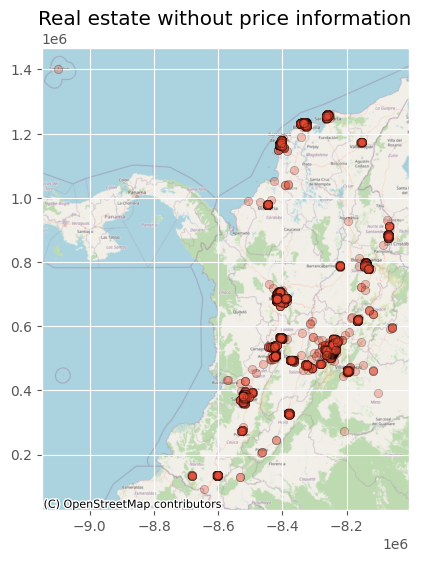

In [48]:
ax = model_df[model_df.precio.isna()].to_crs(epsg=3857).plot(figsize=(6, 6), alpha=0.3, edgecolor="k")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Real estate without price information")

In [49]:
model_df[model_df.precio.isna()].describe()

,latitud,longitud,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad
count,22205.00,22205.00,22205.00,22205.00,22205.00,0.00,22205.00,22205.00,22205.00
mean,5.72,-74.64,2.52,2.21,98.64,NaN,0.56,1.32,11.69
std,1.94,0.96,1.08,0.90,98.48,NaN,0.50,0.69,9.22
min,0.83,-81.73,0.00,1.00,1.00,NaN,0.00,1.00,1.00
25%,4.67,-75.57,2.00,2.00,60.00,NaN,0.00,1.00,4.00
50%,4.73,-74.10,3.00,2.00,75.00,NaN,1.00,1.00,12.00
75%,6.24,-74.05,3.00,3.00,106.00,NaN,1.00,1.00,23.00
max,12.49,-72.39,36.00,5.00,4216.00,NaN,1.00,10.00,30.00


In [50]:
model_df[model_df.precio.isna()].head()

,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
41,5.03,-74.03,CUNDINAMARCA,ZIPAQUIRÁ,2.00,5,152.00,NaN,1,2,12,apartamento,arriendo,POINT (-74.03001 5.02603)
57,5.00,-74.04,CUNDINAMARCA,ZIPAQUIRÁ,3.00,2,86.00,NaN,0,2,4,apartamento,arriendo,POINT (-74.03564 5.00231)
99,5.07,-74.61,CUNDINAMARCA,GUADUAS,4.00,3,157.00,NaN,0,2,4,casa,arriendo,POINT (-74.60970 5.07094)
138,4.70,-74.23,CUNDINAMARCA,MOSQUERA,3.00,2,60.00,NaN,1,1,4,apartamento,arriendo,POINT (-74.23409 4.69909)
199,7.02,-73.12,SANTANDER,GIRÓN,3.00,2,900.00,NaN,0,5,12,casa,arriendo,POINT (-73.12446 7.02196)


In [51]:
model_df[model_df.precio.isna()].tail()

,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
882126,3.43,-76.55,VALLE DEL CAUCA,CALI,3.00,4,137.00,NaN,0,2,4,apartamento,arriendo,POINT (-76.55200 3.43000)
882135,3.44,-76.55,VALLE DEL CAUCA,CALI,3.00,2,122.00,NaN,1,2,23,apartamento,arriendo,POINT (-76.55096 3.43579)
882234,3.41,-76.45,VALLE DEL CAUCA,CANDELARIA,3.00,2,134.00,NaN,0,1,23,casa,arriendo,POINT (-76.45408 3.41096)
882242,3.39,-76.39,VALLE DEL CAUCA,CANDELARIA,3.00,4,108.00,NaN,1,2,4,apartamento,arriendo,POINT (-76.38800 3.39500)
882630,3.26,-76.56,VALLE DEL CAUCA,JAMUNDÍ,3.00,4,112.00,NaN,1,2,4,apartamento,arriendo,POINT (-76.55926 3.25912)


It is decided to eliminate the properties without price due to:

- Although most of these observations are in the central and northern parts of the country, incorrectly imputing these missing data could bias the model output (since `price` is the variable to predict).
- The properties without price represent only 2.5% of the total data.

In [52]:
model_df.dropna(subset="precio", inplace=True)

In [53]:
# Shape of the dataset after handling NAs
print(f"Rows: {model_df.shape[0]}, Cols: {model_df.shape[1]}")

Rows: 859942, Cols: 14


### 5.2 Duplicates

In [54]:
print(f"Duplicates: {model_df.duplicated().sum()}, Duplicates %: {round(model_df.duplicated().sum() * 100/ model_df.shape[0], 2)} %")

Duplicates: 233490, Duplicates %: 27.15 %


Text(0.5, 1.0, 'Location of duplicated real estate offer')

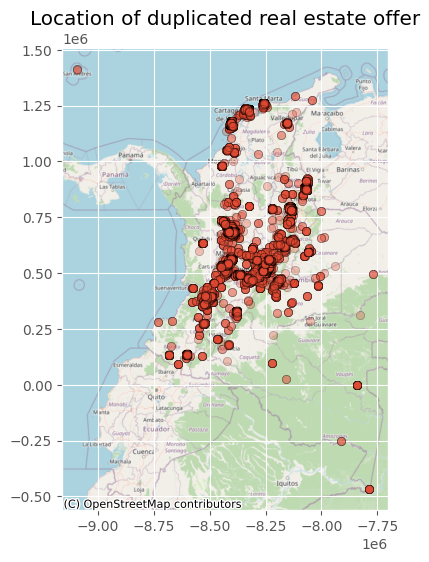

In [55]:
ax = model_df[model_df.duplicated()].to_crs(epsg=3857).plot(figsize=(6, 6), alpha=0.3, edgecolor="k")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Location of duplicated real estate offer")

In [56]:
inmuebles_gdf.iloc[model_df[model_df.duplicated()].index, :].sort_values([c for c in model_df.columns]).head()

,id,fecha_creacion,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,direccion,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
260131,2602839,2021-10-22,-4.19,-69.95,AMAZONAS,LETICIA,3.00,2,125.00,1300000.00,0,1,Km 2 Vía Los Lagos,12,casa,arriendo,POINT (-69.94577 -4.19393)
363706,3222454,2021-12-12,-4.19,-69.95,AMAZONAS,LETICIA,3.00,2,125.00,1300000.00,0,1,Km 2 Vía Los Lagos,12,casa,arriendo,POINT (-69.94577 -4.19393)
519162,3499908,2022-01-27,-4.19,-69.95,AMAZONAS,LETICIA,3.00,2,125.00,1300000.00,0,1,Km 2 Vía Los Lagos,12,casa,arriendo,POINT (-69.94577 -4.19393)
882886,2901914,2021-11-25,-4.19,-69.95,AMAZONAS,LETICIA,3.00,2,125.00,1300000.00,0,1,Km 2 Vía Los Lagos,12,casa,arriendo,POINT (-69.94577 -4.19393)
156037,4390143,2022-05-03,-4.19,-69.95,AMAZONAS,LETICIA,3.00,2,125.00,210000000.00,0,1,Km 2 Vía Los Lagos,12,casa,venta,POINT (-69.94577 -4.19393)


In [57]:
inmuebles_gdf.iloc[model_df[model_df.duplicated()].index, :].sort_values([c for c in model_df.columns]).tail()

,id,fecha_creacion,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,direccion,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
872108,3400075,2022-01-27,11.54,-72.91,LA GUAJIRA,RIOHACHA,3.00,2,92.00,185000000.00,0,1,CALLE 22 # 12 -39 cel 300_3413768,1,casa,venta,POINT (-72.91110 11.53551)
508325,2810700,2021-11-25,11.54,-72.92,LA GUAJIRA,RIOHACHA,4.00,2,102.00,280000000.00,0,1,calle15,12,casa,venta,POINT (-72.91845 11.53747)
882885,2215580,2021-10-07,12.57,-81.71,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",SAN ANDRÉS,1.00,1,68.00,690000000.00,1,1,Avenida 12A # 1 - 141,12,apartamento,venta,POINT (-81.70600 12.57300)
260129,2749481,2021-11-24,12.59,-81.71,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",SAN ANDRÉS,3.00,2,105.00,920000000.00,1,1,CALLE 1 #18 25,1,apartamento,venta,POINT (-81.70500 12.59300)
830642,2986240,2021-12-09,12.59,-81.71,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",SAN ANDRÉS,3.00,2,105.00,920000000.00,1,1,CALLE 1 #18 25,1,apartamento,venta,POINT (-81.70500 12.59300)


After reviewing the duplicate data, two possible hypotheses can explain this phenomenon:

1. **Reposting of real estate:** The same property can be offered on more than one occasion (different creation dates).
2. **Similar properties:** For example, several apartments in the same building. However, in the previous data visualization, there are duplicates with properties that correspond to houses.

Although hypothesis 1 is more strongly supported by the data, it is difficult to know exactly the real cause of the duplicates. With this in mind, and with the fact that we have a large amount of data to fill our model, we will proceed to eliminate this duplicate data.

In [58]:
model_df.drop_duplicates(inplace=True)

In [59]:
# Shape of the dataset after handling duplicates
print(f"Rows: {model_df.shape[0]}, Cols: {model_df.shape[1]}")

Rows: 626452, Cols: 14


### 5.3 Outliers

#### 5.3.1 Price

In order to detect outliers we will perform an inspection of the target variable `price`.

In [60]:
# Descriptive statistics variable `price`
model_df.precio.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame() \
.merge(model_df.precio[model_df.tiponegocio == "venta"] \
    .describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame("precio_venta"), left_index=True, right_index=True) \
.merge(model_df.precio[model_df.tiponegocio == "arriendo"] \
    .describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame("precio_arriendo"), left_index=True, right_index=True)

,precio,precio_venta,precio_arriendo
count,626452.00,435774.00,190678.00
mean,427673951.08,554151406.65,138623369.88
std,31593554983.21,534076424.46,57258737750.93
min,1.00,40000000.00,1.00
1%,690000.00,108000000.00,550000.00
5%,1000000.00,150000000.00,750000.00
10%,1300000.00,180000000.00,870000.00
25%,3300000.00,260000000.00,1200000.00
50%,280000000.00,390000000.00,1700000.00
75%,500000000.00,650000000.00,2700000.00


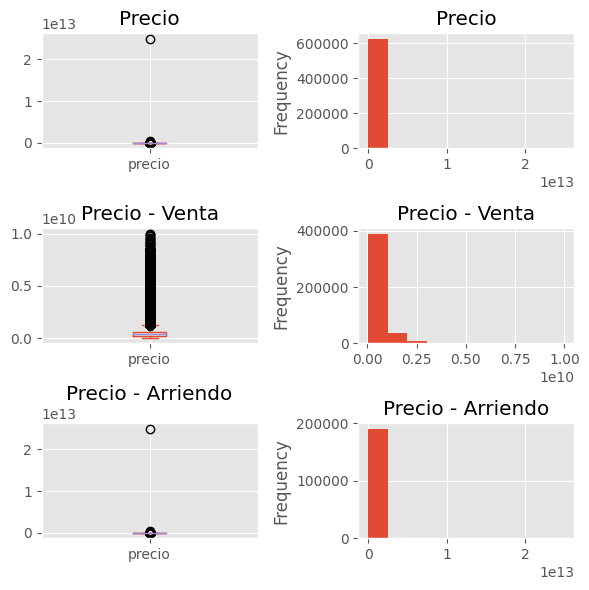

In [61]:
# The distribution of the target variable `price` is displayed
fig, ax = plt.subplots(3, 2, figsize=(6,6))
ax_flat = ax.flatten()
model_df.precio.plot(kind="box", ax=ax_flat[0], title="Precio")
model_df.precio.plot(kind="hist", ax=ax_flat[1], title="Precio")
model_df.precio[model_df.tiponegocio == "venta"].plot(kind="box", ax=ax_flat[2], title="Precio - Venta")
model_df.precio[model_df.tiponegocio == "venta"].plot(kind="hist", ax=ax_flat[3], title="Precio - Venta")
model_df.precio[model_df.tiponegocio == "arriendo"].plot(kind="box", ax=ax_flat[4], title="Precio - Arriendo")
model_df.precio[model_df.tiponegocio == "arriendo"].plot(kind="hist", ax=ax_flat[5], title="Precio - Arriendo")
fig.tight_layout()

In [62]:
model_df[(model_df.precio == model_df.precio.max()) | (model_df.precio == model_df.precio.min())]

,latitud,longitud,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad,tipo_inmueble,tiponegocio,geometry
227988,4.66,-74.11,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",3.00,2,90.00,25000001700000.00,1,1,12,apartamento,arriendo,POINT (-74.11063 4.65716)
571568,6.24,-75.15,ANTIOQUIA,GUATAPÉ,1.00,1,52.00,1.00,0,2,4,apartamento,arriendo,POINT (-75.15140 6.23600)


It is then evident that there are **global outliers**, that is, properties with unrealistic prices. Since these do not correspond to valid data, they will be eliminated, leaving only the data found above the 1st percentile, and below the 99th percentile.

In [63]:
# Remove global outliers
model_df = model_df[(model_df.precio > model_df.precio.quantile(0.01)) & (model_df.precio < model_df.precio.quantile(0.99))]

Now the distribution of the variable of interest is analyzed again.

In [64]:
# Descriptive statistics variable `price`
model_df.precio.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame() \
.merge(model_df.precio[model_df.tiponegocio == "venta"] \
    .describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame("precio_venta"), left_index=True, right_index=True) \
.merge(model_df.precio[model_df.tiponegocio == "arriendo"] \
    .describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame("precio_arriendo"), left_index=True, right_index=True)

,precio,precio_venta,precio_arriendo
count,613773.00,429425.00,184348.00
mean,359315959.43,511537227.39,4727800.13
std,397293045.62,384222934.13,43897836.32
min,690800.00,40000000.00,690800.00
1%,793000.00,108000000.00,700000.00
5%,1100000.00,150000000.00,820000.00
10%,1400000.00,180000000.00,950000.00
25%,3500000.00,260000000.00,1250000.00
50%,280000000.00,385220000.00,1700000.00
75%,498000000.00,630000000.00,2800000.00


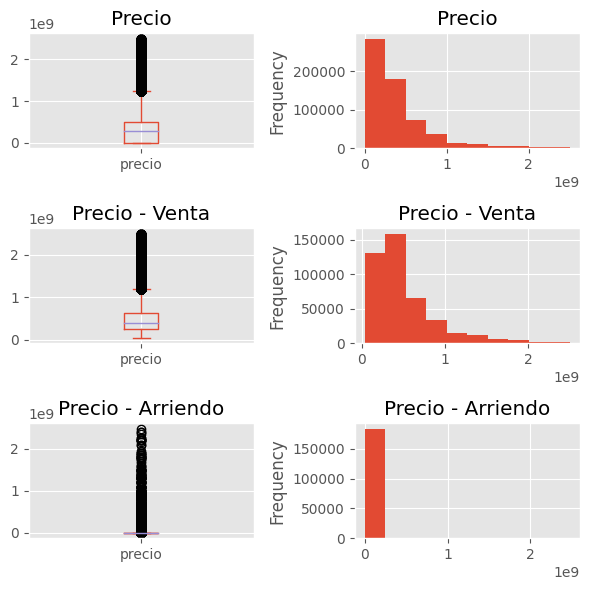

In [65]:
# The distribution of the target variable `price` is displayed
fig, ax = plt.subplots(3, 2, figsize=(6,6))
ax_flat = ax.flatten()
model_df.precio.plot(kind="box", ax=ax_flat[0], title="Precio")
model_df.precio.plot(kind="hist", ax=ax_flat[1], title="Precio")
model_df.precio[model_df.tiponegocio == "venta"].plot(kind="box", ax=ax_flat[2], title="Precio - Venta")
model_df.precio[model_df.tiponegocio == "venta"].plot(kind="hist", ax=ax_flat[3], title="Precio - Venta")
model_df.precio[model_df.tiponegocio == "arriendo"].plot(kind="box", ax=ax_flat[4], title="Precio - Arriendo")
model_df.precio[model_df.tiponegocio == "arriendo"].plot(kind="hist", ax=ax_flat[5], title="Precio - Arriendo")
fig.tight_layout()

The distribution of the `price` variable seems to make more sense after the above operation. However, the distribution of properties published as "rent" still seems to have problems. In order to combat this problem, the records of properties offered for rent that have a price greater than 16 million will be eliminated.

In [66]:
print(f"Rows to remove: {model_df[(model_df.tiponegocio == 'arriendo') & (model_df.precio > 16_000_000)].shape[0]}")

Rows to remove: 1802


In [67]:
# Remove rows with the criteria defined above
model_df = model_df[~((model_df.tiponegocio == 'arriendo') & (model_df.precio > 16_000_000))]

Finally, a verification of the distribution of the variable of interest is carried out again.

In [68]:
# Descriptive statistics variable `price`
model_df.precio.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame() \
.merge(model_df.precio[model_df.tiponegocio == "venta"] \
    .describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame("precio_venta"), left_index=True, right_index=True) \
.merge(model_df.precio[model_df.tiponegocio == "arriendo"] \
    .describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .99]).to_frame("precio_arriendo"), left_index=True, right_index=True)

,precio,precio_venta,precio_arriendo
count,611971.00,429425.00,182546.00
mean,359661379.89,511537227.39,2385483.36
std,397308506.42,384222934.13,2012839.73
min,690800.00,40000000.00,690800.00
1%,790000.00,108000000.00,700000.00
5%,1100000.00,150000000.00,820000.00
10%,1390000.00,180000000.00,950000.00
25%,3500000.00,260000000.00,1225000.00
50%,280000000.00,385220000.00,1700000.00
75%,499000000.00,630000000.00,2700000.00


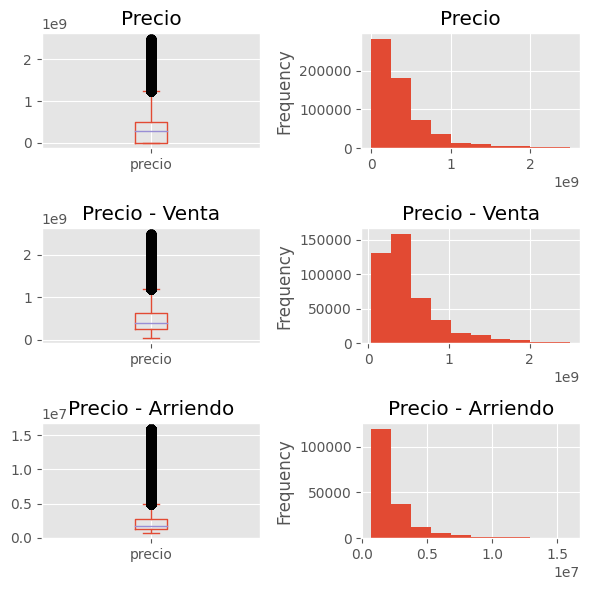

In [69]:
# The distribution of the target variable `price` is displayed
fig, ax = plt.subplots(3, 2, figsize=(6,6))
ax_flat = ax.flatten()
model_df.precio.plot(kind="box", ax=ax_flat[0], title="Precio")
model_df.precio.plot(kind="hist", ax=ax_flat[1], title="Precio")
model_df.precio[model_df.tiponegocio == "venta"].plot(kind="box", ax=ax_flat[2], title="Precio - Venta")
model_df.precio[model_df.tiponegocio == "venta"].plot(kind="hist", ax=ax_flat[3], title="Precio - Venta")
model_df.precio[model_df.tiponegocio == "arriendo"].plot(kind="box", ax=ax_flat[4], title="Precio - Arriendo")
model_df.precio[model_df.tiponegocio == "arriendo"].plot(kind="hist", ax=ax_flat[5], title="Precio - Arriendo")
fig.tight_layout()

#### 5.3.2 Other variables

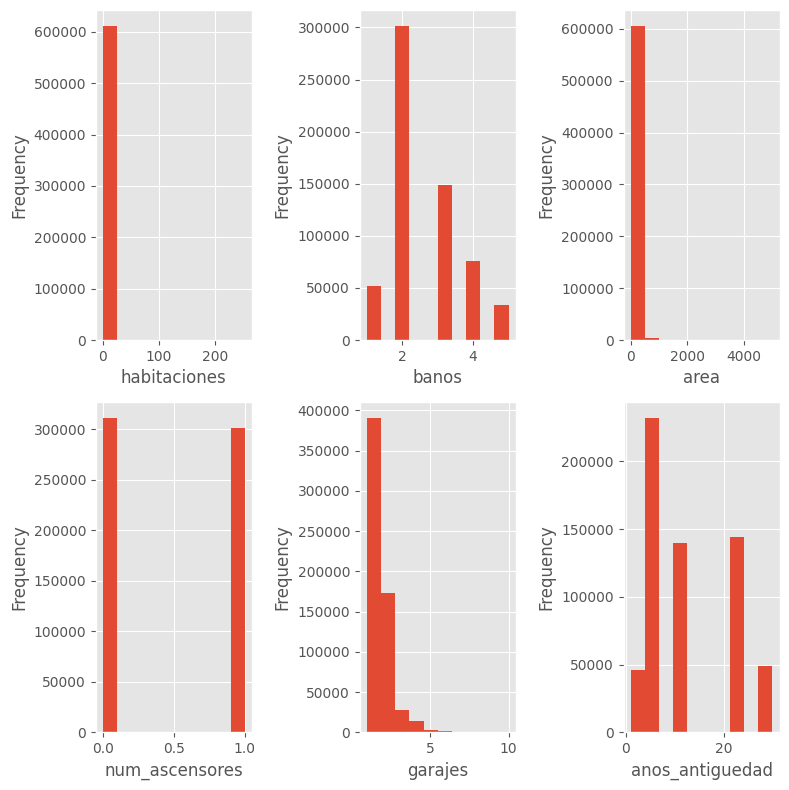

In [70]:
vars = ["habitaciones", "banos", "area", "num_ascensores", "garajes", "anos_antiguedad"]
fig, ax = plt.subplots(2, 3, figsize=(8, 8))
ax_flat = ax.flatten()
for idx, var in enumerate(vars):
    model_df[var].plot(kind="hist", ax=ax_flat[idx])
    ax_flat[idx].set_xlabel(var)
fig.tight_layout()

In particular, the variables `rooms` and `area` call attention.

In [71]:
# The descriptive statistics of the variables are reviewed
model_df[["habitaciones", "area"]].describe(percentiles=[.01, .25, .5, .75, .90, .99, .9999])

,habitaciones,area
count,611971.00,611971.00
mean,2.96,127.94
std,1.26,151.17
min,0.00,1.00
1%,1.00,35.98
25%,2.00,68.00
50%,3.00,92.00
75%,3.00,145.00
90%,4.00,230.00
99%,7.00,500.30


In the same way, we proceed to leave the observations that are above the 1st percentile and below the 99th percentile for both variables.

In [72]:
# Observations are eliminated according to the established criteria
model_df = model_df[(model_df.habitaciones >= model_df.habitaciones.quantile(.01)) & (model_df.habitaciones <= model_df.habitaciones.quantile(.99))]
model_df = model_df[(model_df["area"] >= model_df["area"].quantile(.01)) & (model_df["area"] <= model_df["area"].quantile(.99))]

### 5.4 EDA

#### 5.4.1 Numeric features

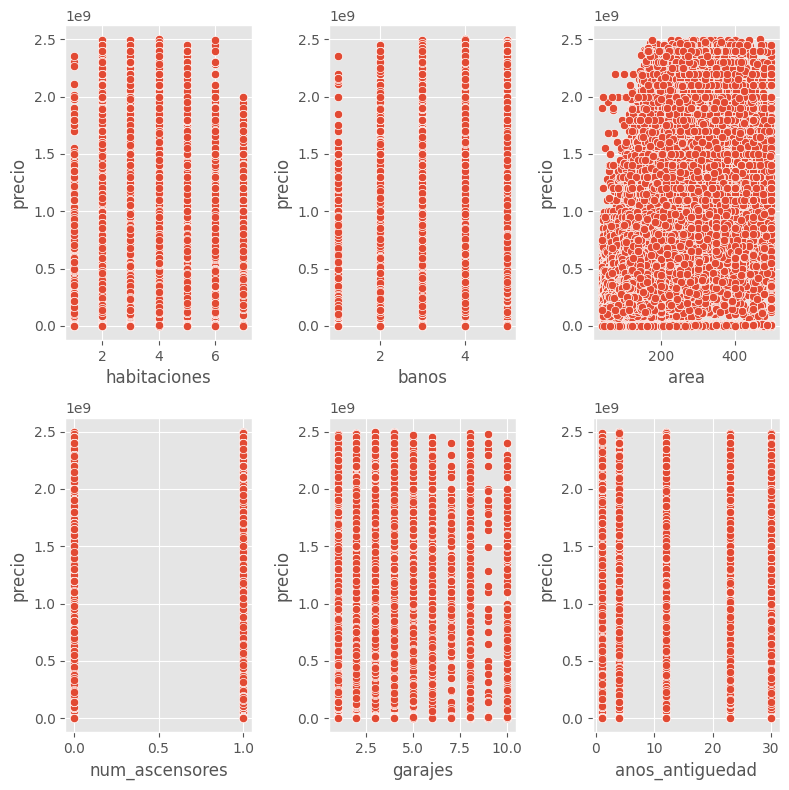

In [73]:
vars = ["habitaciones", "banos", "area", "num_ascensores", "garajes", "anos_antiguedad"]
fig, ax = plt.subplots(2, 3, figsize=(8, 8))
ax_flat = ax.flatten()
for idx, var in enumerate(vars):
    sns.scatterplot(data=model_df, y="precio", x=var, ax=ax_flat[idx])
fig.tight_layout()

<Axes: >

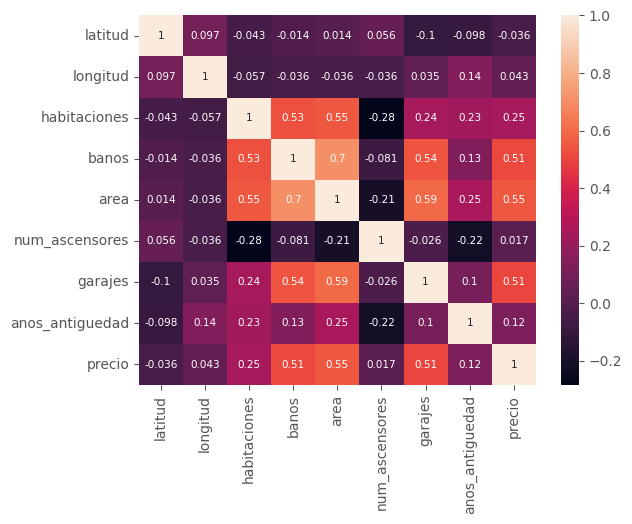

In [74]:
sns.heatmap(model_df[[
    "latitud", "longitud", "habitaciones", "banos", "area", "num_ascensores", "garajes", "anos_antiguedad", "precio"
    ]].corr(), annot=True, annot_kws={"size": 7.5})

#### 5.4.2 Categorical features

Text(0.5, 0, 'Price (COP)')

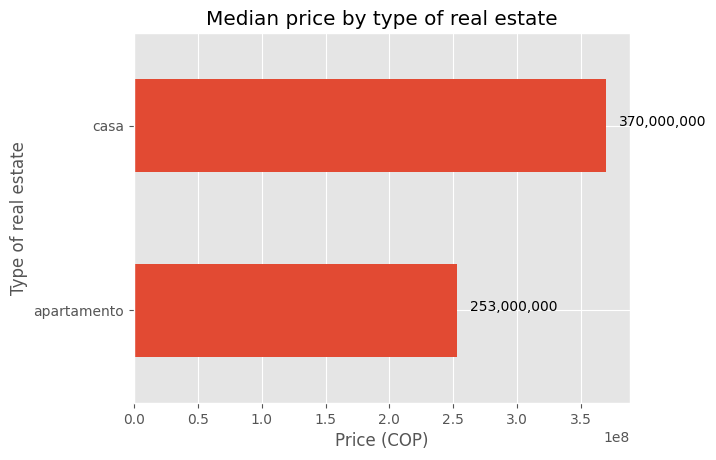

In [75]:
grouped = model_df.groupby("tipo_inmueble")["precio"].median().sort_values()
ax = grouped.plot(kind="barh")
for i, v in enumerate(grouped):
    ax.text(v + 1e7, i, '{:,}'.format(int(v)))
plt.title("Median price by type of real estate")
plt.ylabel("Type of real estate")
plt.xlabel("Price (COP)")

Text(0.5, 0, 'Price (COP)')

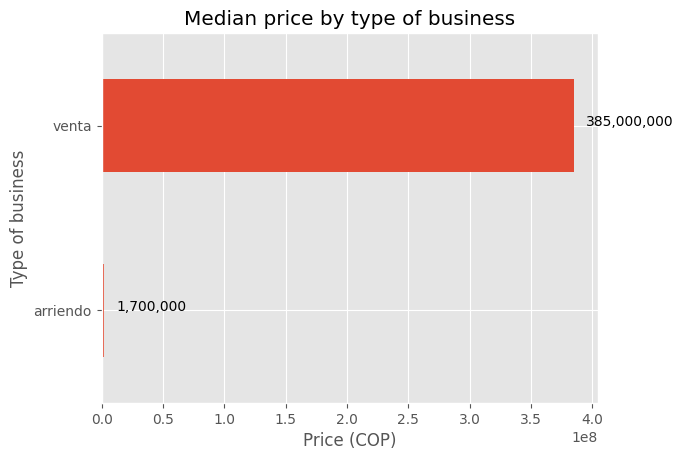

In [76]:
grouped = model_df.groupby("tiponegocio")["precio"].median().sort_values()
ax = grouped.plot(kind="barh")
for i, v in enumerate(grouped):
    ax.text(v + 1e7, i, '{:,}'.format(int(v)))
plt.title("Median price by type of business")
plt.ylabel("Type of business")
plt.xlabel("Price (COP)")

Text(0.5, 0, 'Price (COP)')

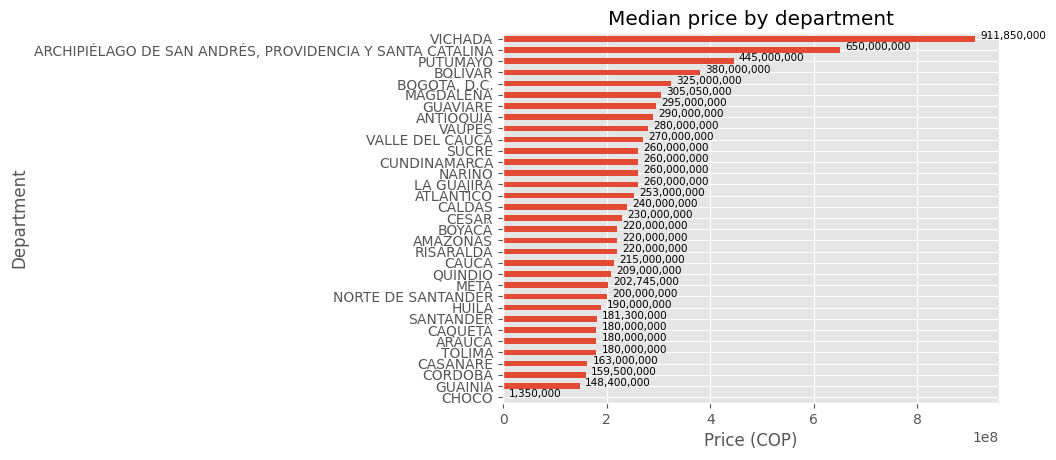

In [77]:
grouped = model_df.groupby("departamento")["precio"].median().sort_values()
ax = grouped.plot(kind="barh")
for i, v in enumerate(grouped):
    ax.text(v + 1e7, i, '{:,}'.format(int(v)), size=7.5)
plt.title("Median price by department")
plt.ylabel("Department")
plt.xlabel("Price (COP)")

Text(0.5, 0, 'Price (COP)')

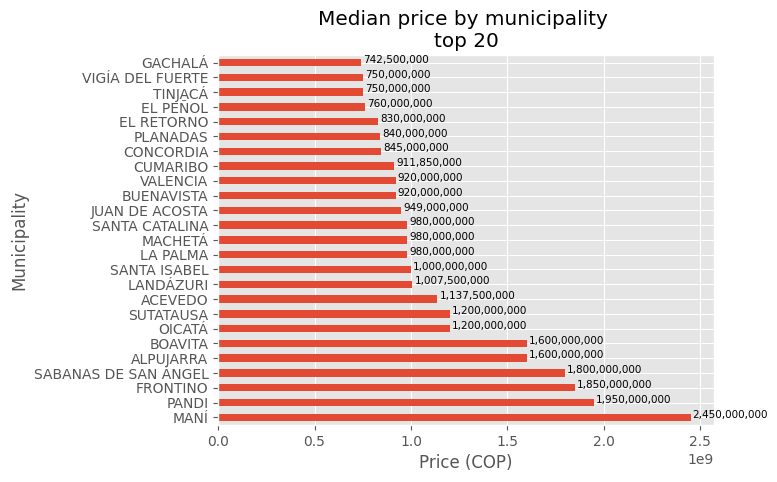

In [78]:
grouped = model_df.groupby("municipio")["precio"].median().nlargest(25)
ax = grouped.plot(kind="barh")
for i, v in enumerate(grouped):
    ax.text(v + 1e7, i, '{:,}'.format(int(v)), size=7.5)
plt.title("Median price by municipality \ntop 20")
plt.ylabel("Municipality")
plt.xlabel("Price (COP)")

### 5.5 Train and test split

In [79]:
# Split dataset into features and label
X, y = model_df.drop(["precio", "geometry"], axis=1), model_df["precio"]
print(X.shape, y.shape)

(593872, 12) (593872,)


In [80]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1399, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(445404, 12) (445404,)
(148468, 12) (148468,)


### 5.6 Feature Engineering + Baseline Models

In order to produce a baseline model, categorical data is coded as follows:
- `property_type` and `businesstype`: since they have low cardinality, a OneHotEncoder will be used to process them.
- `departamento` and `municipio`: since they have high cardinality, a different approach to the OHE is needed. The following encoders will be tested [`CountEncoder`, `TargetEncoder`, `OrdinalEncoder`, `CatBoostEncoder`]

In [81]:
# The OHE is used to code the low cardinality categorical variables
ohe = ce.OneHotEncoder(verbose=1, cols=["tipo_inmueble", "tiponegocio"], use_cat_names=True)
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [82]:
# Several encoders are defined to encode the variables categories of high cardinality
encoders = [ce.CountEncoder(), ce.OrdinalEncoder(), ce.CatBoostEncoder(), ce.TargetEncoder()]

The following models will be tested (along with each encoder specified above):

- Linear Regression (cuML)
-KNN (cuML)
-RandomForest (cuML)
-Light GBM
-XGBoost

**Note: It is not necessary to use cuML, with scikit-learn you can do the same procedure as below**

In [83]:
# Define the models to test
linear_regression = cuml.LinearRegression()
knn = cuml.KNeighborsRegressor()
random_forest = cuml.RandomForestRegressor(random_state=1399, n_streams=1)
light_gbm = LGBMRegressor(n_jobs=-1, random_state=1399)
xg_boost = XGBRegressor(tree_method="gpu_hist", n_jobs=-1, random_state=1399)

models = [linear_regression, knn, random_forest, light_gbm, xg_boost]
model_names = ["Linear Regression", "K-Nearest Neighbors", "Random Forest", "LightGBM", "XGBoost"]

In [84]:
results_df = pd.DataFrame(columns=["Model", "Encoder", "RMSE", "MAPE"])

for encoder in encoders:
    encoder_name = encoder.__class__.__name__
    # Check if the encoder requires y in the fit method
    if encoder_name in ['TargetEncoder', 'CatBoostEncoder']:
        X_train_encoded = encoder.fit_transform(X_train, y_train)
        X_test_encoded = encoder.transform(X_test)
    else:
        X_train_encoded = encoder.fit_transform(X_train)
        X_test_encoded = encoder.transform(X_test)
    
    # Convert encoded datasets to cuDF dataframes for cuML models
    X_train_cudf = cudf.DataFrame.from_pandas(X_train_encoded)
    X_test_cudf = cudf.DataFrame.from_pandas(X_test_encoded)

    for model in models:
        model_name = model.__class__.__name__
        # Check if the model is from cuML and convert the data accordingly
        if 'cuml' in str(model.__class__):
            model.fit(X_train_cudf, y_train)
            y_pred = model.predict(X_test_cudf)
            if isinstance(y_pred, cudf.Series):
                y_pred = y_pred.to_numpy()
        else:
            model.fit(X_train_encoded, y_train)
            y_pred = model.predict(X_test_encoded)
        
        # Calculate the metrics
        rmse_score = mean_squared_error(y_test, y_pred, squared=False)
        mape_score = mean_absolute_percentage_error(y_test, y_pred)
        
        # Save the results
        results_df = pd.concat([results_df, pd.DataFrame([{'Model': model_name, 'Encoder': encoder_name, 'RMSE': rmse_score, 'MAPE': mape_score}])], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Below are the results of the models trained and evaluated on the test dataset.

In [86]:
results_df.sort_values("MAPE")

,Model,Encoder,RMSE,MAPE
2,RandomForestRegressor,CountEncoder,112886713.94,0.17
17,RandomForestRegressor,TargetEncoder,114407377.91,0.17
7,RandomForestRegressor,OrdinalEncoder,113812291.79,0.17
12,RandomForestRegressor,CatBoostEncoder,116905648.72,0.18
3,LGBMRegressor,CountEncoder,122536326.42,0.94
8,LGBMRegressor,OrdinalEncoder,122568239.34,0.94
18,LGBMRegressor,TargetEncoder,122746589.21,1.02
13,LGBMRegressor,CatBoostEncoder,122799470.68,1.03
9,XGBRegressor,OrdinalEncoder,119053695.61,1.67
19,XGBRegressor,TargetEncoder,118784383.40,1.70


The model that has shown the best performance in our prediction task is the RandomForestRegressor, using a CountEncoder for the preprocessing of categorical variables. This model has obtained an RMSE of 112886713.94 and a MAPE of 0.17.

The RMSE (Root Mean Squared Error) is a measure of how much the model's predictions deviate from the actual values. An RMSE of 112886713.94 means that, on average, our predictions deviate from the actual value by approximately 112.8 million.

On the other hand, the MAPE (Mean Absolute Percentage Error) measures the size of the errors in percentage of the real values. A MAPE of 0.17 implies that, on average, our predictions are 17% above or below the true value.

It is important to note that while this model has proven to be the best based on these metrics, it is always helpful to consider other performance measures and understand the specific needs of your use case when interpreting these results.

In order to improve these results the following steps should be performed:
- Add new features based on knowledge of the field.
- Test logarithmic transformation to the target.
- Add interactions between variables and their polynomials.
- Optimization of hyperparameters of the best model.